In [60]:
# N-number seed
import random
random.seed(16540081)  

# Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
# Load data
df = pd.read_csv("musicData.csv")

In [20]:
# Replace problematic values (like -1 or '?') with NaN
df.replace(['?', -1], np.nan, inplace=True)

# Drop rows with missing genre
df.dropna(subset=['music_genre'], inplace=True)

# Handle missing values for numerical features
num_cols = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Convert 'key' into numerical code
df['key'] = df['key'].astype('category').cat.codes

# One-hot encode 'mode'
mode_dummies = pd.get_dummies(df['mode'], prefix='mode', drop_first=True)
df = pd.concat([df.drop(columns=['mode']), mode_dummies], axis=1)

# Label encode the genre
label_encoder = LabelEncoder()
df['genre_label'] = label_encoder.fit_transform(df['music_genre'])

# Drop unused and unnecessary columns
df = df.drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'])

In [70]:
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,mode_Minor,genre_label
0,27.0,0.00468,0.652,245503.541466,0.941,0.79200,1,0.115,-5.201,0.0748,100.889,0.759,1,5
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,5,0.124,-7.043,0.0300,115.002,0.531,1,5
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,11,0.534,-4.617,0.0345,127.994,0.333,0,5
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,4,0.157,-4.498,0.2390,128.014,0.270,0,5
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,9,0.157,-6.266,0.0413,145.036,0.323,0,5


In [14]:
train_data, test_data = [], []

# Group by genre label and split 500 for test
for genre_label in df['genre_label'].unique():
    genre_df = df[df['genre_label'] == genre_label]
    genre_df = genre_df.sample(frac=1, random_state=16540081)  # shuffle
    
    test_data.append(genre_df.iloc[:500])
    train_data.append(genre_df.iloc[500:])

train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

X_train = train_df.drop(columns=["genre_label"])
y_train = train_df["genre_label"]

X_test = test_df.drop(columns=["genre_label"])
y_test = test_df["genre_label"]

# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [34]:
# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled[num_cols])

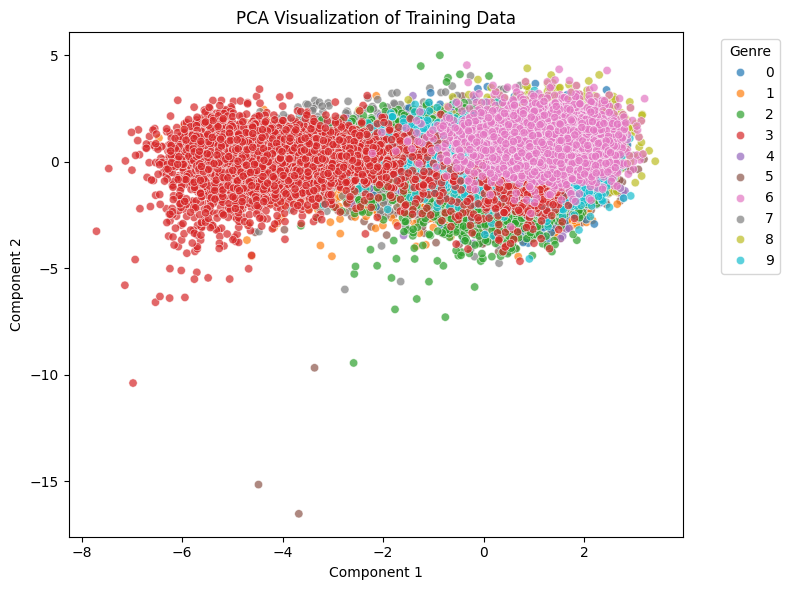

In [36]:
# Plot genres in PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='tab10', alpha=0.7)
plt.title("PCA Visualization of Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [38]:
# KMeans Clustering on PCA-reduced space
kmeans = KMeans(n_clusters=10, random_state=16540081)
clusters = kmeans.fit_predict(X_pca)

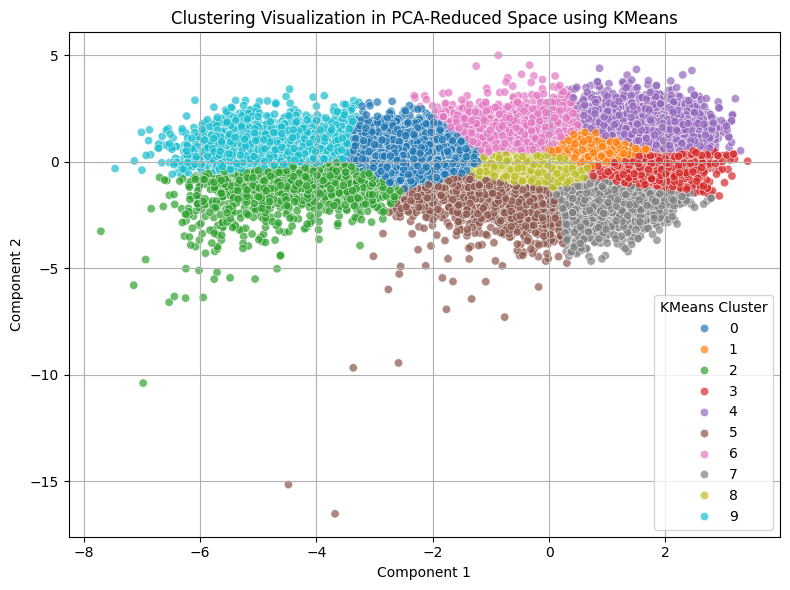

In [64]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='tab10', alpha=0.7)
plt.title("Clustering Visualization in PCA-Reduced Space using KMeans")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="KMeans Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Classification with Random Forest and Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=16540081), param_grid, scoring='roc_auc_ovr', cv=3, verbose=1)
grid.fit(X_train_scaled, y_train)

# Best model after tuning
best_rf = grid.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [46]:
# Extract results into a DataFrame
results_df = pd.DataFrame(grid.cv_results_)

summary = results_df[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'mean_test_score']]
summary = summary.sort_values(by='mean_test_score', ascending=False)

In [52]:
# Display the top results
print("GridSearchCV Results (Sorted by AUC):")
print(summary.head())

# Print the best hyperparameters
print("Best parameters found:")
print(grid.best_params_)

# Print the best AUC score
print(f"Best AUC for training set: {grid.best_score_:.4f}")

GridSearchCV Results (Sorted by AUC):
   param_n_estimators param_max_depth  param_min_samples_split  \
3                 200              10                        5   
1                 200              10                        2   
2                 100              10                        5   
0                 100              10                        2   
7                 200              20                        5   

   mean_test_score  
3         0.925550  
1         0.925468  
2         0.925041  
0         0.924921  
7         0.923928  
Best parameters found:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best AUC for training set: 0.9255


AUC on the test set: 0.9272


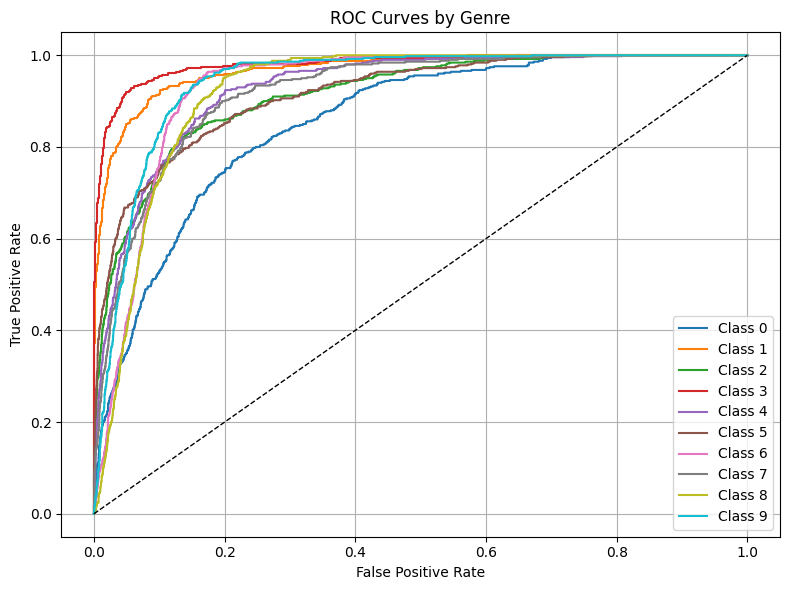

In [66]:
# Predict and Evaluate AUC
y_pred_proba = best_rf.predict_proba(X_test_scaled)
final_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC on the test set: {final_auc:.4f}")

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(len(set(y_test))):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Genre")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

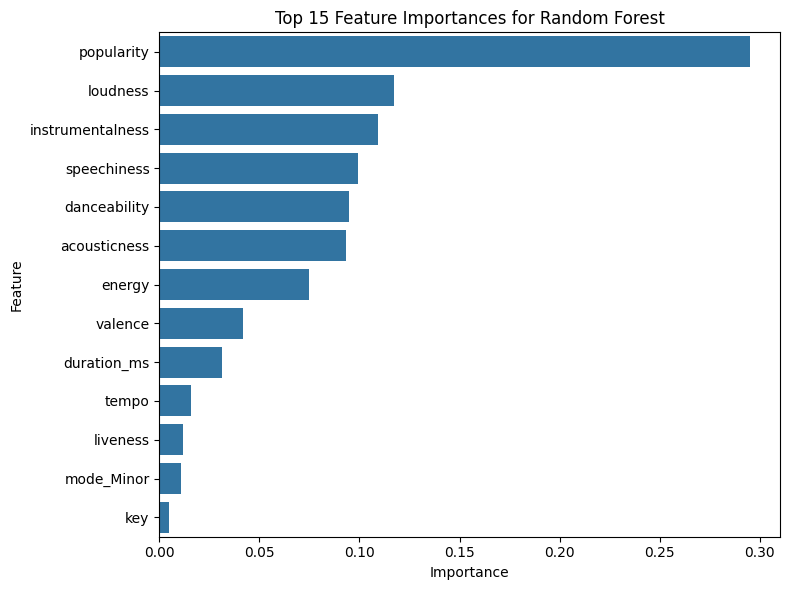

In [68]:
# Get feature importances from the best model
importances = best_rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame for sorting and plotting
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(15))
plt.title('Top 15 Feature Importances for Random Forest')
plt.tight_layout()
plt.show()

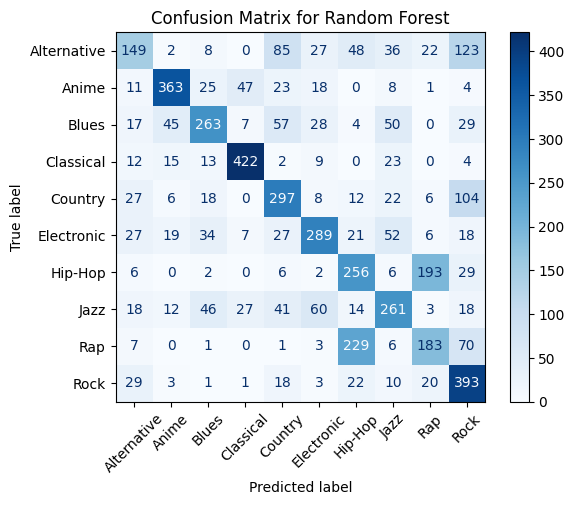

In [62]:
# confusion matrix to show where the classifier performs best and where it struggles
cm = confusion_matrix(y_test, best_rf.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Random Forest")
plt.show()